<a href="https://colab.research.google.com/github/ArezooArdekani/spatially_varying_diffusion/blob/main/PINNs_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inverse resolution of spatially varying diffusion coefficient using physics informed neural networks

Resolving the diffusion coefficient is a key element in many biological and engineering systems, including pharmacological drug transport and fluid mechanics analyses. Here, we present an inverse solver that uses physics informed neural networks (PINNs) to calculate spatially-varying diffusion coefficients from image data.



We first load the dataset of images.

In [1]:
import gdown

In [2]:
# Google Drive file ID
file_id = '1akSDShRp5w5iryi_pYWerg3QqvdMGoiG' #Case 1
#file_id = '1wuRcFT82sKLlBvtcHdOhv0xWdAfWCvTx' #Case 2
#file_id = '1zEfx76C67EE351ZzGWNXv4-Yfn-6B3P8' #Case 3
#file_id = '10Xdxi8Hbi8RsKKuMxsBqJxNr-FOdCqr-' #Case 4

# URL for downloading the file using gdown
url = f'https://drive.google.com/uc?id={file_id}'

# Destination file path where the downloaded file will be saved
output = 'data.mat'

# Download the file using gdown
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1akSDShRp5w5iryi_pYWerg3QqvdMGoiG
From (redirected): https://drive.google.com/uc?id=1akSDShRp5w5iryi_pYWerg3QqvdMGoiG&confirm=t&uuid=d447270f-ac18-4879-a50a-837cd44e85bc
To: /content/data.mat
100%|██████████| 244M/244M [00:02<00:00, 108MB/s] 


'data.mat'

In [3]:
### If you want to use wandb to track the results

#pip install wandb


We now import all the necessary libraries.

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
import random
from random import randint
#import wandb
import scipy.stats
import math

np.random.seed(1234)
tf.random.set_seed(1234)

### Function definitions

We define our neural network class here.

In [5]:

class NeuralNet(object):
    def __init__(self, *inputs, layers):

        self.layers = layers
        self.num_layers = len(self.layers)

        if len(inputs) == 0:
            in_dim = self.layers[0]
            self.X_mean = np.zeros([1, in_dim])
            self.X_std = np.ones([1, in_dim])
        else:
            X = np.concatenate(inputs, 1)
            self.X_mean = X.mean(0, keepdims=True)
            self.X_std = X.std(0, keepdims=True)

        self.weights = []
        self.biases = []
        self.gammas = []
        initializer = tf.initializers.glorot_uniform()

        for l in range(0,self.num_layers-1):
            in_dim = self.layers[l]
            out_dim = self.layers[l+1]
            W = np.random.normal(size=[in_dim, out_dim])
            b = np.zeros([1, out_dim])
            g = np.ones([1, out_dim])
            # tensorflow variables
            self.weights.append(tf.Variable(W, dtype=tf.float32, trainable=True, name=str(random.randint(1,10000))))
            self.biases.append(tf.Variable(b, dtype=tf.float32, trainable=True))
            self.gammas.append(tf.Variable(g, dtype=tf.float32, trainable=True))

    def get_trainable_variables(self):
        return self.weights + self.biases + self.gammas

    def __call__(self, *inputs):

        H = (tf.concat(inputs, 1) - self.X_mean)/self.X_std

        for l in range(0, self.num_layers-1):
            W = self.weights[l]
            b = self.biases[l]
            g = self.gammas[l]
            # weight normalization
            V = W/tf.norm(W, axis = 0, keepdims=True)
            # matrix multiplication
            H = tf.matmul(H, V)
            # add bias
            H = g*H + b
            # activation
            if l < self.num_layers-2:
                H = H*tf.sigmoid(H)

        Y = tf.split(H, num_or_size_splits=H.shape[1], axis=1)

        return Y


We define the functions to calculate the gradients, the relative error and the mean squared error.


In [6]:
@tf.custom_gradient
def fwd_gradients(dy, dx):
    def grad(dy_dx):
        with tf.GradientTape() as tape:
            tape.watch(dx)
            G = tf.gradients(dy, dx, grad_ys=dy_dx)[0]
        return G

    return grad

def relative_error(pred, exact):
    if isinstance(pred, np.ndarray):
        return np.sqrt(np.mean(np.square(pred - exact)) / np.mean(np.square(exact - np.mean(exact))))
    return tf.sqrt(tf.reduce_mean(tf.square(pred - exact)) / tf.reduce_mean(tf.square(exact - tf.reduce_mean(exact))))

def mean_squared_error(pred, exact):
    if isinstance(pred, np.ndarray):
        return np.mean(np.square(pred - exact))
    return tf.reduce_mean(tf.square(pred - exact))


### Data Processing

We create a dataset to train the neural network. We first read the file.

In [7]:
### Load data ###
data = scipy.io.loadmat('./data.mat')

Diff_star = data['Diff_star'] # N x T  #Comment this out for image data [When the diffusion coefficient is unknown]
C_star = data['C_star'] # N x T
t_star = data['t'].T # T x 1
X_star = data['X_star'] # N x 2

x_star = X_star[:,0:1]
y_star = X_star[:,1:2]



And now, we process the data.

In [8]:
N = x_star.shape[0]
T = t_star.shape[0]

x_mesh = np.tile(x_star,(1,T)).flatten()[:,None]
y_mesh = np.tile(y_star,(1,T)).flatten()[:,None]
t_mesh = np.tile(t_star, (1,N)).T.flatten()[:,None]

c_mesh_data = C_star.flatten()[:,None]
d_mesh_data = Diff_star.flatten()[:,None]   # Comment this out for image data

idx_x = np.random.choice( x_mesh.shape[0], x_mesh.shape[0], replace=False)      # Randomly select data points

x_data = np.float32(x_mesh[idx_x,:])
y_data = np.float32(y_mesh[idx_x,:])
t_data = np.float32(t_mesh[idx_x,:])

c_data = np.float32(c_mesh_data[idx_x,:])
d_data = np.float32(d_mesh_data[idx_x,:])   # Comment this out for image data

dt = (t_star[1] - t_star[0])

# Randomize dataset
idx = np.random.choice(N*T, N*T, replace=False)
idx_test = np.random.choice(N*T, int(0.1*N*T), replace=False)

t_eqns = np.float32(np.random.uniform(low=t_data.min(), high=t_data.max(), size=(256000000,t_data.shape[1])))
x_eqns = np.float32(np.random.uniform(low=x_data.min(), high=x_data.max(), size=(256000000,t_data.shape[1])))
y_eqns = np.float32(np.random.uniform(low=y_data.min(), high=y_data.max(), size=(256000000,t_data.shape[1])))

t_test_set = np.float32(t_mesh[idx_test,:])
x_test_set = np.float32(x_mesh[idx_test,:])
y_test_set = np.float32(y_mesh[idx_test,:])
c_test_set = np.float32(c_mesh_data[idx_test,:])
d_test_set = np.float32(d_mesh_data[idx_test,:])   # Comment this out for image data

We define tensorflow dataset iterators here to train the neural network efficiently.

In [9]:
# Dataset creation using tf.data
batch_size = 256

# Dataset initialization
train_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, t_data, c_data, d_data))
#train_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, t_data, c_data))  # Use this for image data
train_dataset = train_dataset.shuffle(buffer_size=10).repeat().batch(batch_size, drop_remainder=True)
train_iterator = iter(train_dataset)

eqns_dataset = tf.data.Dataset.from_tensor_slices((x_eqns, y_eqns, t_eqns))
eqns_dataset = eqns_dataset.shuffle(buffer_size=10).repeat().batch(batch_size, drop_remainder=True)
eqns_iterator = iter(eqns_dataset)


### Create the neural networks



We define the hyperparameters for the neural networks here.

In [10]:
# Create neural networks
layers = [3] + 8 * [64] + [1]
layers_D = [2] + 2 * [8] + [1]
c_net = NeuralNet(x_data, y_data, t_data, layers = layers)
D_net = NeuralNet(x_data, y_data, layers = layers_D)

In [11]:
it = 0
N_iter = 320000  #Number of iterations

eta_min = 2.5e-6  #Minimum value of the learning rate
eta_max = 2.5e-3  #Maximum value of the learning rate


start_time = time.time()
running_time = 0

# Training the network

In [12]:
optimizer = tf.keras.optimizers.Adam()

@tf.function
def compute_gradients(x_data_tf, y_data_tf, t_data_tf, c_data_tf, d_data_tf, x_eqns_tf, y_eqns_tf, t_eqns_tf, dt):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x_eqns_tf, y_eqns_tf])
        dt = tf.cast(dt, tf.float32)

        c_data_pu_1, c_eqns_pu_1, c_eqns_pu_2, D_pred_, D_pred_data = c_net(x_data_tf, y_data_tf, t_data_tf)[0], \
                                                                     c_net(x_eqns_tf, y_eqns_tf, t_eqns_tf)[0], \
                                                                     c_net(x_eqns_tf, y_eqns_tf, t_eqns_tf + dt)[0], \
                                                                     D_net(x_eqns_tf, y_eqns_tf)[0], \
                                                                     D_net(x_data_tf, y_data_tf)[0]

        c_x = tape.gradient([c_eqns_pu_2], [x_eqns_tf])[0]
        c_y = tape.gradient([c_eqns_pu_2], [y_eqns_tf])[0]
        D_x = tape.gradient([D_pred_], [x_eqns_tf])[0]
        D_y = tape.gradient([D_pred_], [y_eqns_tf])[0]
        c_xx = tape.gradient([c_x], [x_eqns_tf])[0]
        c_yy = tape.gradient([c_y], [y_eqns_tf])[0]

        f_c = D_pred_ * (c_xx + c_yy) + D_x * c_x + D_y * c_y
        c_eqns_pi_1 = c_eqns_pu_2 - dt * f_c

        scale_c = np.std(c_data)
        scale_d = np.std(d_data)

        loss_data = mean_squared_error(c_data_pu_1 / scale_c, c_data_tf / scale_c)
        loss_diff = mean_squared_error(D_pred_data / scale_d, d_data_tf / scale_d)    # Comment this out for image data
        loss_consistency = mean_squared_error(c_eqns_pu_1 / scale_c, c_eqns_pi_1 / scale_c)

        total_loss = loss_data + loss_consistency

    gradients = tape.gradient(total_loss, c_net.get_trainable_variables() + D_net.get_trainable_variables())
    optimizer.apply_gradients(zip(gradients, c_net.get_trainable_variables() + D_net.get_trainable_variables()))

    #return loss_data, loss_consistency   Use this for image data
    return loss_data, loss_diff, loss_consistency

Here is the training loop.

In [13]:
# Training loop
while it < N_iter:
    lr = eta_min + 0.5 * (eta_max - eta_min) * (1 + np.cos(math.pi * it / N_iter))

    optimizer.learning_rate.assign(lr)
    x_data_tf, y_data_tf, t_data_tf, c_data_tf, d_data_tf = next(train_iterator)
    x_eqns_tf, y_eqns_tf, t_eqns_tf = next(eqns_iterator)

    # Training step
    loss_data, loss_diff, loss_consistency = compute_gradients( x_data_tf, y_data_tf, t_data_tf, c_data_tf, d_data_tf,
                                                              x_eqns_tf, y_eqns_tf, t_eqns_tf, dt)

    ''' #Use this for image data
    loss_data, loss_diff, loss_consistency = compute_gradients( x_data_tf, y_data_tf, t_data_tf, c_data_tf, d_data_tf,
                                                              x_eqns_tf, y_eqns_tf, t_eqns_tf, dt)
    '''
    # Logging and progress monitoring
    if it % 10 == 0:
        elapsed = time.time() - start_time
        running_time += elapsed / 3600.0
        print(f"It: {it}, Loss_data: {loss_data.numpy():.3e}, Loss_f: {loss_consistency.numpy():.3e}, "
              f"Loss_diff: {loss_diff.numpy():.3e}, Time: {elapsed:.2f}s, Running Time: {running_time:.2f}h, "
              f"Learning Rate: {lr:.1e}")
        ''' #Use this for image data
        print(f"It: {it}, Loss_data: {loss_data.numpy():.3e}, Loss_f: {loss_consistency.numpy():.3e}, "
              f"Time: {elapsed:.2f}s, Running Time: {running_time:.2f}h, "
              f"Learning Rate: {lr:.1e}")
        '''
        # Log using WandB or other logging method
        #wandb.log({'It': it, 'loss_d': loss_data.numpy(), 'loss_con': loss_consistency.numpy(),'loss_diff': loss_diff.numpy(),  'LR':lr})
        start_time = time.time()
    it += 1
    if it % 1000 == 0:
        c_star_val, d_star_val = c_net(x_test_set, y_test_set, t_test_set), D_net(x_test_set, y_test_set)
        #wandb.log({'Error_c':relative_error(c_star_val, c_test_set), 'Error_d':relative_error(d_star_val, d_test_set) })

Streaming output truncated to the last 5000 lines.
It: 270000, Loss_data: 1.607e-07, Loss_f: 3.118e-08, Loss_diff: 2.342e-03, Time: 4.63s, Running Time: 1.53h, Learning Rate: 1.5e-04
It: 270010, Loss_data: 2.205e-07, Loss_f: 2.296e-08, Loss_diff: 3.122e-03, Time: 0.16s, Running Time: 1.53h, Learning Rate: 1.5e-04
It: 270020, Loss_data: 8.131e-08, Loss_f: 2.000e-08, Loss_diff: 3.301e-03, Time: 0.16s, Running Time: 1.53h, Learning Rate: 1.5e-04
It: 270030, Loss_data: 6.371e-08, Loss_f: 2.456e-08, Loss_diff: 2.554e-03, Time: 0.17s, Running Time: 1.53h, Learning Rate: 1.5e-04
It: 270040, Loss_data: 8.444e-08, Loss_f: 3.518e-08, Loss_diff: 2.971e-03, Time: 0.17s, Running Time: 1.53h, Learning Rate: 1.5e-04
It: 270050, Loss_data: 2.118e-07, Loss_f: 2.300e-08, Loss_diff: 2.478e-03, Time: 0.15s, Running Time: 1.53h, Learning Rate: 1.5e-04
It: 270060, Loss_data: 1.472e-07, Loss_f: 3.616e-08, Loss_diff: 4.136e-03, Time: 0.17s, Running Time: 1.53h, Learning Rate: 1.5e-04
It: 270070, Loss_data: 1.

### Prediction and plotting

Once the network is trained, we plot the results.

In [14]:
c_star_val, d_star_val = c_net(x_test_set, y_test_set, t_test_set), D_net(x_test_set, y_test_set)
print(relative_error(c_star_val, c_test_set))
print(relative_error(d_star_val, d_test_set))

tf.Tensor(0.00020307394, shape=(), dtype=float32)
tf.Tensor(0.05507609, shape=(), dtype=float32)


In [15]:
C_pred_val = np.zeros_like(C_star)
D_star_val = D_net(np.float32(X_star[:,0:1]), np.float32(X_star[:,1:2]))[0]

TT = np.tile(t_star, (1,N)).T

for snp in range(C_star.shape[1]-1):
    snap = np.array([snp])
    c_star_val =  c_net(np.float32(X_star[:,0:1]), np.float32(X_star[:,1:2]), np.float32(TT[:,snap]))[0]
    C_pred_val[:,snap] = c_star_val



In [ ]:
# Predict for plotting
lb = X_star.min(0)
ub = X_star.max(0)
nn = 200
x = np.linspace(lb[0], ub[0], nn)
y = np.linspace(lb[1], ub[1], nn)
X, Y = np.meshgrid(x,y)


In [ ]:
DIFF_star = griddata(X_star, Diff_star[:,0].flatten(), (X, Y), method='cubic')
d_min = np.min(DIFF_star.flatten())
d_max = np.max(DIFF_star.flatten())
levels_diff = np.arange(d_min,d_max,(d_max-d_min)/100)


extend_diff = "both"
cmap = plt.cm.get_cmap("seismic")


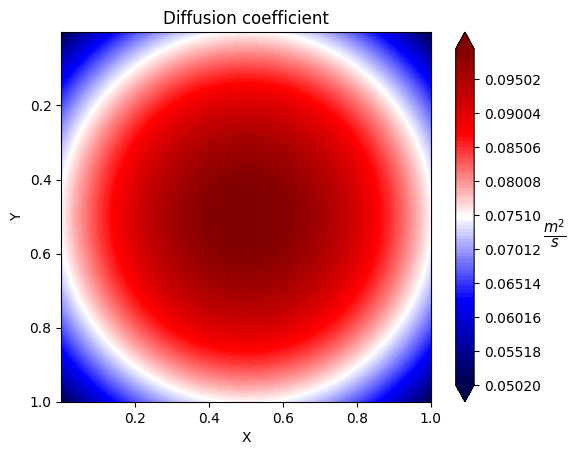

In [18]:
fig3, ax3 = plt.subplots()
CS3 = ax3.contourf(X, Y, (DIFF_star), levels=levels_diff, cmap=cmap,extend=extend_diff)
ax3.set_title(r'Diffusion coefficient')# $[\frac{m^2}{s}]$')
ax3.set_aspect('equal')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
cbar = plt.colorbar(CS3,) #, format=ticker.FuncFormatter(fmt))
cbar.set_label(r'$\frac{m^2}{s}$',rotation=-0, labelpad=10,size=15)
plt.gca().invert_yaxis()


In [19]:
DIFF_pred = griddata(X_star, D_star_val.numpy().flatten(), (X, Y), method='cubic')

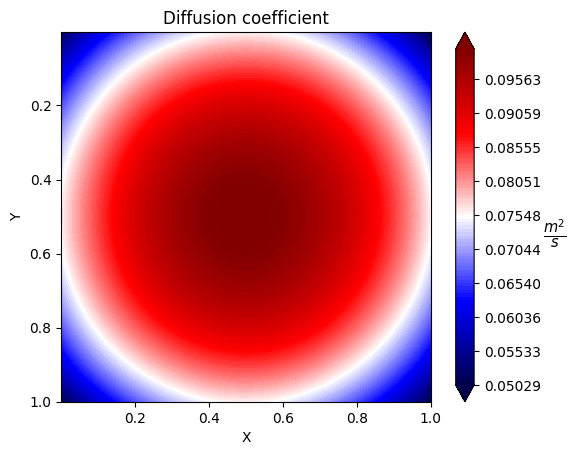

In [20]:
d_min = np.min(DIFF_pred.flatten())
d_max = np.max(DIFF_pred.flatten())
levels_diff = np.arange(d_min,d_max,(d_max-d_min)/100)

fig3, ax3 = plt.subplots()
CS3 = ax3.contourf(X, Y, (DIFF_pred), levels=levels_diff, cmap=cmap,extend=extend_diff)
ax3.set_title(r'Diffusion coefficient')# $[\frac{m^2}{s}]$')
ax3.set_aspect('equal')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
cbar = plt.colorbar(CS3,) #, format=ticker.FuncFormatter(fmt))
cbar.set_label(r'$\frac{m^2}{s}$',rotation=-0, labelpad=10,size=15)
plt.gca().invert_yaxis()
